## Brio-Wu

Avec ce premier problème nous souhaitons tester les solveurs `hlld` et `fivewaves` de `fv2d`, et les comparer aux solveurs hlld et Roe de Athena++. Mis à part les solveurs, nous utiliserons une grille de 512 points et une CFL de 0,4. La reconstruction spatiale utilisée par défaut sera une _PLM_, combinée à un schéma temporel _Runge-Kutta_ d'ordre 2. On note que la divergence de $\vec{B}$ ne pose pas de problème en 1D et ne sera pas étudiée ici.

### Problem Set Up

In [1]:
from datahandler import Fv2dCode, AthenaCode, IniFile
from pathlib import Path
home = Path().home() / "Documents" / "programmes"

In [ ]:
ini_file = IniFile(home/"fv2d/settings/mhd_sod_x.ini")
ini_file.set_param("mesh", "Nx", 512)
ini_file.set_param("solvers", "CFL", 0.4)
ini_file.set_param("physics", "gamma0", 2.0)

# HLLD solver + RK2
ini_file.set_param("solvers", "riemann_solver", "hlld")
ini_file.write("brio_wu.ini")

# HLLD solver + RK2 without div cleaning
ini_file.set_param("solvers", "riemann_solver", "hlld")
ini_file.set_param("solvers", "div_cleaning", "none")
ini_file.write("brio_wu_nodc.ini")

# Five waves solver + RK2 and div cleaning
ini_file.set_param("solvers", "riemann_solver", "fivewaves")
ini_file.write("brio_wu_5w.ini")

# Five waves solver + Euler time stepping and div cleaning
ini_file.set_param("solvers", "riemann_solver", "fivewaves")
ini_file.set_param("solvers", "time_stepping", "euler")
ini_file.write("brio_wu_5w_euler.ini")

# HLLD solver + Euler time stepping
ini_file.set_param("solvers", "riemann_solver", "hlld")
ini_file.set_param("solvers", "time_stepping", "euler")
ini_file.set_param("solvers", "div_cleaning", "none")
ini_file.write("brio_wu_euler.ini")

In [ ]:
# Compile and run the code
fv2d = Fv2dCode(base_path=home/"fv2d")
fv2d.compile()
fv2d.run(inifile="brio_wu.ini")
fv2d.run(inifile="brio_wu_nodc.ini")
fv2d.run(inifile="brio_wu_5w.ini")
fv2d.run(inifile="brio_wu_5w_euler.ini")
fv2d.run(inifile="brio_wu_euler.ini")


In [ ]:
athena = AthenaCode(home/"athena")
ini_file = IniFile(home/"athena/inputs/mhd/athinput.bw", athena_fmt=True)
ini_file.set_param("mesh", "nx1", 512)
ini_file.set_param("time", "cfl_number", 0.4)
ini_file.set_param("time", "tlim", 0.2)
ini_file.write("athinput.bw")
athena.compile(ini_file)
athena.run(inifile="athinput.bw")

### Data Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datahandler import AthenaTabular, Fv2DH5
from pathlib import Path

In [ ]:
athena_data_path = Path("athena_output")
athena_data_file = list(sorted(athena_data_path.glob("*.tab")))[-1]
athena_data = AthenaTabular(athena_data_file)
athena_data.rescale() # by default on this test, the domain on AThena is [-0.5, 0.5] and on fv2d is [0, 1]

In [ ]:
# hlld + RK2 Data
fv2d_data_path = Path("fv2d_output")
fv2d_data = Fv2DH5(fv2d_data_path/"run_brio_wu.h5", reshape=True)
fv2d_data_5w = Fv2DH5(fv2d_data_path/"run_brio_wu_5w.h5", reshape=True) # fv2d outputs are 2D; we select only a slice along x
fv2d_data_5we = Fv2DH5(fv2d_data_path/"run_brio_wu_5w_euler.h5", reshape=True) # fv2d outputs are 2D; we select only a slice along x
fv2d_data_e = Fv2DH5(fv2d_data_path/"run_brio_wu_euler.h5", reshape=True) # fv2d outputs are 2D; we select only a slice along x
fv2d_data_nodc = Fv2DH5(fv2d_data_path/"run_brio_wu_nodc.h5", reshape=True) # fv2d outputs are 2D; we select only a slice along x

In [ ]:
def plot_attrs(attr, *, longname=None, title="Brio-Wu Test") -> None:
    """ Plot the given attribute for all the data sets.
    Parameters
    ----------
    attr : str
        The attribute to plot.
    longname : str
        The long name of the attribute to plot, used for the $y$-axis.
        If None, the attribute name will be used.
    """
    plt.figure(figsize=(10, 10))
    plt.plot(athena_data.x, getattr(athena_data, attr), '--k', label="Athena-hlld")
    plt.plot(fv2d_data.x, getattr(fv2d_data, attr), '--', label="FV2D-hlld-RK2")
    plt.plot(fv2d_data_5w.x, getattr(fv2d_data_5w, attr), '--', label="FV2D-5waves-RK2")
    plt.plot(fv2d_data_5we.x, getattr(fv2d_data_5we, attr), '--', label="FV2D-5waves-Euler")
    plt.plot(fv2d_data_e.x, getattr(fv2d_data_e, attr), '--', label="FV2D-hlld-Euler")
    plt.plot(fv2d_data_nodc.x, getattr(fv2d_data_nodc, attr), '--', label="FV2D-hlld-noDC")
    plt.title(title)
    if longname is not None:
        plt.ylabel(longname)
    else:
        plt.ylabel(attr)
    plt.xlabel("x")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
plot_attrs("rho", longname=r"$\rho$")
plot_attrs("u", longname=r"$v_x$")
plot_attrs("v", longname=r"$v_y$")
plot_attrs("p", longname=r"$P$")
# plot_attrs("Bx", longname=r"$B_x$")
plot_attrs("By", longname=r"$B_y$")
# plot_attrs("Bz", longname=r"$B_z$")

### Error Analysis

In [ ]:
from typing import Callable


def absolute_error(y: np.ndarray, y_ref: np.ndarray) -> np.ndarray:
    """ Compute the absolute error between two arrays.
    Parameters
    ----------
    y : np.ndarray
        The data to compare.
    y_ref : np.ndarray
        The reference data.
    Returns
    -------
    np.ndarray
        The absolute error between the two arrays.
    """
    return np.abs(y - y_ref)


def relative_error(y: np.ndarray, y_ref: np.ndarray, norm_ord=1) -> np.ndarray:
    """ Compute the relative error between two arrays.
    Parameters
    ----------
    y : np.ndarray
        The data to compare.
    y_ref : np.ndarray
        The reference data.
    Returns
    -------
    np.ndarray
        The relative error between the two arrays.
    """
    return np.abs(y - y_ref) / np.abs(y_ref)

def plot_error(attr: str, *, longname: str=None, error_type: Callable = relative_error, norm_ord=2, scale='log') -> None:
    """ Plot the error between the data sets.
    Parameters
    ----------
    attr : str
        The attribute to plot.
    longname : str
        The long name of the attribute to plot, used for the $y$-axis.
        If None, the attribute name will be used.
    error_type : Callable
        The error function to use. Can be either absolute_error or relative_error.
    norm_ord : int
        The order of the norm to use. Default is 2.
    """

    plt.figure(figsize=(10, 10))
    e1 = error_type(getattr(fv2d_data, attr), getattr(athena_data, attr))
    e2 = error_type(getattr(fv2d_data_5w, attr), getattr(athena_data, attr))
    e3 = error_type(getattr(fv2d_data_5we, attr), getattr(athena_data, attr))
    e4 = error_type(getattr(fv2d_data_e, attr), getattr(athena_data, attr))
    e5 = error_type(getattr(fv2d_data_nodc, attr), getattr(athena_data, attr))
    plt.plot(fv2d_data.x, e1, '--', label=f"FV2D-hlld-RK2, L{norm_ord}-norm= {np.linalg.norm(e1, ord=norm_ord)/len(e1):.2e}")
    plt.plot(fv2d_data.x, e2, '--', label=f"FV2D-5waves-RK2, L{norm_ord}-norm= {np.linalg.norm(e2, ord=norm_ord)/len(e2):.2e}")
    plt.plot(fv2d_data.x, e3, '--', label=f"FV2D-5waves-Euler, L{norm_ord}-norm= {np.linalg.norm(e3, ord=norm_ord)/len(e3):.2e}")
    plt.plot(fv2d_data.x, e4, '--', label=f"FV2D-hlld-Euler, L{norm_ord}-norm= {np.linalg.norm(e4, ord=norm_ord)/len(e4):.2e}")
    plt.plot(fv2d_data.x, e5, '--', label=f"FV2D-hlld-noDC, L{norm_ord}-norm= {np.linalg.norm(e5, ord=norm_ord)/len(e5):.2e}")
    plt.title("Brio-Wu Test")
    plt.ylim(1e-6, 1e0)
    if longname is not None:
        plt.ylabel(longname)
    else:
        plt.ylabel(attr)
    plt.xlabel("x")
    plt.yscale(scale)
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
plot_error("rho", longname=r"$\rho$", error_type=absolute_error)
plot_error("u", longname=r"$v_x$", error_type=absolute_error)
plot_error("v", longname=r"$v_y$", error_type=absolute_error)
plot_error("p", longname=r"$P$", error_type=absolute_error)
plot_error("By", longname=r"$B_y$", error_type=absolute_error)

### Convergence Analysis

Le but est ici de tester la convergence de nos différents solveurs selon la taille du maillage, i.e. le nombre de cellules. Nous choissisons de tester chaque solveurs pour les valeurs suivantes $Nx=32, 64, 128 , 256, 512$

In [2]:
from datahandler import Fv2dCode, IniFile, AthenaCode
from pathlib import Path
home = Path().home() / "Documents" / "programmes"

In [3]:
# generate all the ini_files for the different tests
original_ini = home/"fv2d/settings/mhd_sod_x.ini"
athena_ini = home/"athena/inputs/mhd/athinput.bw"
for solver in ["hlld", "fivewaves"]:
    for time_stepping in ["RK2", "euler"]:
        for i in range(5, 10):
            new_ini = f"brio_wu_{2**i:04d}_{solver}_{time_stepping}.ini"
            ini = IniFile(original_ini)
            ini.set_param("mesh", "Nx", 2**i)
            ini.set_param("solvers", "riemann_solver", solver)
            ini.set_param("solvers", "time_stepping", time_stepping)
            ini.set_param("solvers", "div_cleaning", "none")
            ini.set_param("solvers", "CFL", 0.4)
            ini.set_param("physics", "gamma0", 2.0)
            ini.write(new_ini)
            at_ini = IniFile(athena_ini, athena_fmt=True)
            at_ini.set_param("mesh", "nx1", 2**i)
            at_ini.set_param("time", "cfl_number", 0.4)
            at_ini.set_param("time", "tlim", 0.2)
            at_ini.write(f"athinput_{2**i:04d}.bw")

In [4]:
# Here we assume (we know) that the fv2d code is already compiled
# and that the athena code is already compiled
ath_output = Path('athena_output')
for item in Path().glob("athinput_*.bw"):
    athena = AthenaCode(home/"athena")
    this_output = ath_output / item.stem.replace("athinput_", "")
    this_output.mkdir(exist_ok=True, parents=True)
    athena.run(inifile=item.name, destination=this_output)

In [5]:
fv2d = Fv2dCode(base_path=home/"fv2d")
# fv2d.compile()
fv2d_output = Path('fv2d_output')
with open('fv2d.log', 'w') as f:
    f.write("FV2D runs\n")

files = list(sorted(Path().glob("brio_wu_*.ini")))
for i, item in enumerate(files):
    with open('fv2d.log', 'a') as f:
        f.write(f"[{i+1}/{len(files)}] - Run {item.name} started\n")
    nx = item.stem.split("_")[2]
    this_output = fv2d_output / nx
    this_output.mkdir(exist_ok=True, parents=True)
    fv2d.run(inifile=item.name, destination=this_output)
    with open('fv2d.log', 'a') as f:
        f.write(f"[{i+1}/{len(files)}] - Run {item.name} finished\n")

In [6]:
from datahandler import Fv2DH5, AthenaTabular
import numpy as np
import matplotlib.pyplot as plt

In [7]:
athena_data = {}
fv2d_data = {}
errors = {"-".join(algo.split('_')[:-1]): [] for algo in fv2d_data}
for i in range(5, 10):
    dirname = Path("athena_output") / f"{2**i:04d}"
    item = list(sorted(dirname.glob("*.tab")))[-1]
    athena_data[f"{2**i:04d}"] = AthenaTabular(item)
    athena_data[f"{2**i:04d}"].rescale() # by default on AThena is [-0.5, 0.5] and on fv2d is [0, 1]
    item = list(sorted(Path(f"fv2d_output/{2**i:04d}").glob("*.h5")))
    fv2d_data[f"{2**i:04d}"] = [(str(it.stem), Fv2DH5(it, reshape=True)) for it in item]

Reshaping to Nx =  32
Reshaping to Nx =  32
Reshaping to Nx =  32
Reshaping to Nx =  32
Reshaping to Nx =  64
Reshaping to Nx =  64
Reshaping to Nx =  64
Reshaping to Nx =  64
Reshaping to Nx =  128
Reshaping to Nx =  128
Reshaping to Nx =  128
Reshaping to Nx =  128
Reshaping to Nx =  256
Reshaping to Nx =  256
Reshaping to Nx =  256
Reshaping to Nx =  256
Reshaping to Nx =  512
Reshaping to Nx =  512
Reshaping to Nx =  512
Reshaping to Nx =  512


In [9]:
errors = {"-".join(algo[0].split('_')[-2:]):[] for algo in list(fv2d_data.values())[0]}
for i in range(5, 10):
    nx = f"{2**i:04d}"
    for algo, val in fv2d_data[nx]:
        algo = "-".join(algo.split('_')[-2:]) # on veut rassembler les algo
        err = np.linalg.norm(val.rho - athena_data[nx].rho, ord=2)/int(nx)
        print(f"error {algo} = {err:.2e}")
        errors[algo].append(err)

error fivewaves-RK2 = 4.63e-03
error fivewaves-euler = 4.13e-03
error hlld-RK2 = 2.25e-03
error hlld-euler = 1.46e-03
error fivewaves-RK2 = 2.87e-03
error fivewaves-euler = 2.57e-03
error hlld-RK2 = 1.38e-03
error hlld-euler = 9.06e-04
error fivewaves-RK2 = 1.60e-03
error fivewaves-euler = 1.43e-03
error hlld-RK2 = 7.77e-04
error hlld-euler = 5.53e-04
error fivewaves-RK2 = 9.07e-04
error fivewaves-euler = 8.04e-04
error hlld-RK2 = 4.62e-04
error hlld-euler = 3.25e-04
error fivewaves-RK2 = 5.06e-04
error fivewaves-euler = 4.39e-04
error hlld-RK2 = 2.73e-04
error hlld-euler = 1.87e-04


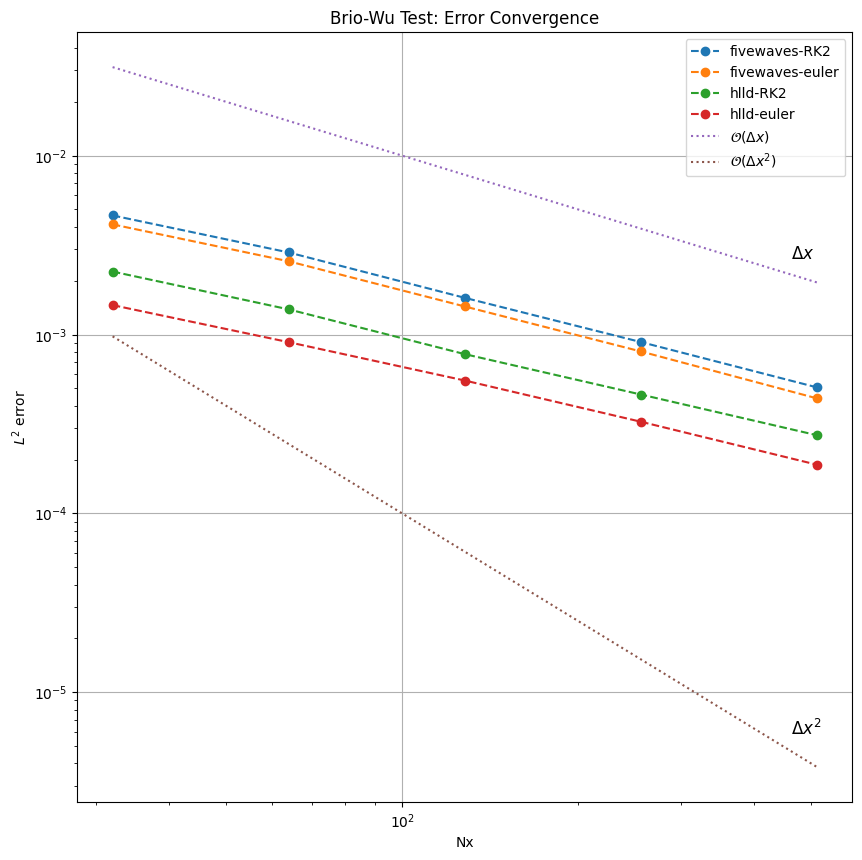

In [10]:
plt.figure(figsize=(10, 10))
for algo, err in errors.items():
    plt.plot([2**i for i in range(5, 10)], err, '--o', label=algo)
plt.title("Brio-Wu Test: Error Convergence")
# Add first and second-order convergence trends
nx_values = np.array([2**i for i in range(5, 10)])
dx_values = 1 / nx_values
plt.plot(nx_values, dx_values, ':', label=r"$\mathcal{O}(\Delta x)$")
plt.plot(nx_values, dx_values**2, ':', label=r"$\mathcal{O}(\Delta x^2)$")

# Add text annotation for second-order trend
plt.text(nx_values[-1]-50, -3e-6 + dx_values[-1]**2 / dx_values[0]**2 * errors['hlld-RK2'][0], r"$\Delta x^2$", fontsize=12)
plt.text(nx_values[-1]-50, 2.5e-3 + dx_values[-1] / dx_values[0] * errors['hlld-RK2'][0], r"$\Delta x$", fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Nx")
plt.ylabel(r"$L^2$ error")
plt.legend()
plt.grid()
plt.show()